# Spanish Sign Language Gesture Detection

The aim of this notebook is to make a first approach to the detection of Spanish sign language gestures. For this purpose, a limited set of words (Abajo, Amigo, Casa, Sentir, Colegio and Cerveza) have been selected and different videos have been taken to capture their movements.  These movements will be captured with the help of the Mediapipe library.

Mediapipe is an open-source library developed by Google that performs automatic detection of different body parts. Thanks to this library, the relative position of each point in an image or a video can be easily detected. The goal, or rather the main idea, is to obtain the coordinates of the different gestures and from these, to be able to infer which gestures are being performed.

![Mediapipe](https://google.github.io/mediapipe/images/mobile/holistic_sports_and_gestures_example.gif)

In [1]:
# Imports
import os
import cv2
import pandas as pd
import pickle 
import matplotlib as plt
import numpy as np
import mediapipe as mp
from mediapipe.python.solutions.face_mesh_connections import FACEMESH_CONTOURS
from sklearn.pipeline import make_pipeline 
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, plot_confusion_matrix,accuracy_score
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC

In [2]:
mp_drawing = mp.solutions.drawing_utils 
mp_holistic = mp.solutions.holistic 

# 1. Create dataset



In [3]:
# Create Dataframe columns names
coords = ["x", "y", "z"]
## Columns names list
list_column_names = []
## WORD
list_column_names.append("Word")
## RIGHT HAND
count = 0
# Code to access the landmarks
for landmark in mp_holistic.HandLandmark:
    for coord in coords:
        list_column_names.append("R"+str(landmark) + "_" + str(count) + "_" + coord)
    count+=1
## LEFT HAND
count = 0
# Code to access the landmarks
for landmark in mp_holistic.HandLandmark:
    for coord in coords:
        list_column_names.append("L"+str(landmark) + "_" + str(count) + "_" + coord)
    count+=1
## POSE
count = 0
# Code to access the landmarks
for landmark in mp_holistic.PoseLandmark:
    for coord in coords:
        list_column_names.append(str(landmark) + "_" + str(count) + "_" + coord)
    count+=1
    if count == 15:
        break

In [6]:
df = pd.DataFrame(columns = [list_column_names])
df

NameError: name 'list_column_names' is not defined

In [ ]:
# Read Videos
path = "../Train_Dataset/"
words = [words for words in os.listdir(path) if os.path.isdir(os.path.join(path, words))]
# All videos must have the same resolution (400x300)
HEIGHT = 600
WIDTH  = 900
for word in words:
    for video in os.listdir(os.path.join(path, word)):
        # Path to each video
        video_path = os.path.join(os.path.join(path, word), video)
        print(video_path)
        # Capture video
        cap = cv2.VideoCapture(video_path)
        # Initialize holistic model
        with mp_holistic.Holistic(min_detection_confidence = 0.5, min_tracking_confidence = 0.5) as holistic:
            while cap.isOpened():
                # Read frame
                ret, frame = cap.read()
                if ret == True:
                    # Resize frame
                    #frame = cv2.resize(frame, (WIDTH, HEIGHT), interpolation = cv2.INTER_AREA)
                    # Change color from BGR to RGB
                    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                    frame.flags.writeable = False
                    # Detect landmarks
                    results = holistic.process(frame)
                    try:
                        # Add coords to list row
                        row = []
                        # The name of the word is added to the row list.
                        row.append(word)
                        ## Get rhand landmarks
                        for landmark in results.right_hand_landmarks.landmark:
                            row.append(landmark.x)
                            row.append(landmark.y)
                            row.append(landmark.z)
                        ## Get lhand landmarks
                        for landmark in results.left_hand_landmarks.landmark:
                            row.append(landmark.x)
                            row.append(landmark.y)
                            row.append(landmark.z)
                        ## Get pose landmarks
                        count = 0
                        for landmark in results.pose_landmarks.landmark:
                            row.append(landmark.x)
                            row.append(landmark.y)
                            row.append(landmark.z)
                            count += 1
                            if count == 15:
                                break
                        df.loc[len(df)] = row
                    except:
                        pass
                else:
                    break
            cap.release()

../Train_Dataset/Abajo\word-abajo-001-f-r10-rs10.avi
../Train_Dataset/Abajo\word-abajo-001-f-r10-rs13.avi
../Train_Dataset/Abajo\word-abajo-001-f-r10-t25-rs10.avi
../Train_Dataset/Abajo\word-abajo-001-f-r10-t25-rs13.avi
../Train_Dataset/Abajo\word-abajo-001-f-r10-t25.avi
../Train_Dataset/Abajo\word-abajo-001-f-r10-t30-rs10.avi
../Train_Dataset/Abajo\word-abajo-001-f-r10-t30-rs13.avi
../Train_Dataset/Abajo\word-abajo-001-f-r10-t30.avi
../Train_Dataset/Abajo\word-abajo-001-f-r10.avi
../Train_Dataset/Abajo\word-abajo-001-f-r13-rs10.avi
../Train_Dataset/Abajo\word-abajo-001-f-r13-rs13.avi
../Train_Dataset/Abajo\word-abajo-001-f-r13-t25-rs10.avi
../Train_Dataset/Abajo\word-abajo-001-f-r13-t25-rs13.avi
../Train_Dataset/Abajo\word-abajo-001-f-r13-t25.avi
../Train_Dataset/Abajo\word-abajo-001-f-r13-t30-rs10.avi
../Train_Dataset/Abajo\word-abajo-001-f-r13-t30-rs13.avi
../Train_Dataset/Abajo\word-abajo-001-f-r13-t30.avi
../Train_Dataset/Abajo\word-abajo-001-f-r13.avi
../Train_Dataset/Abajo\word-

# MACHINE LEARNING

# Train

In [7]:
df = pd.read_csv('data.csv')

In [8]:
df

,Word,RHandLandmark.WRIST_0_x,RHandLandmark.WRIST_0_y,RHandLandmark.WRIST_0_z,RHandLandmark.THUMB_CMC_1_x,RHandLandmark.THUMB_CMC_1_y,RHandLandmark.THUMB_CMC_1_z,RHandLandmark.THUMB_MCP_2_x,RHandLandmark.THUMB_MCP_2_y,RHandLandmark.THUMB_MCP_2_z,...,PoseLandmark.LEFT_SHOULDER_11_z,PoseLandmark.RIGHT_SHOULDER_12_x,PoseLandmark.RIGHT_SHOULDER_12_y,PoseLandmark.RIGHT_SHOULDER_12_z,PoseLandmark.LEFT_ELBOW_13_x,PoseLandmark.LEFT_ELBOW_13_y,PoseLandmark.LEFT_ELBOW_13_z,PoseLandmark.RIGHT_ELBOW_14_x,PoseLandmark.RIGHT_ELBOW_14_y,PoseLandmark.RIGHT_ELBOW_14_z
0,Abajo,0.440598,0.783921,-2.366612e-07,0.456324,0.744731,-0.019115,0.488569,0.721949,-0.028583,...,-0.076862,0.278362,0.462741,-0.162137,0.791987,0.570950,-0.406257,0.230211,0.762704,-0.394085
1,Abajo,0.438445,0.783089,-2.491245e-07,0.456896,0.744480,-0.016129,0.490010,0.721718,-0.023793,...,-0.011478,0.278908,0.463437,-0.152372,0.791986,0.570950,-0.292670,0.230245,0.762779,-0.377853
2,Abajo,0.443570,0.780087,-1.923205e-07,0.462270,0.742764,-0.015684,0.493633,0.721211,-0.023362,...,0.079940,0.279700,0.464741,-0.169411,0.788502,0.558375,-0.187706,0.230808,0.763529,-0.428225
3,Abajo,0.448515,0.780262,-2.180878e-07,0.463991,0.741014,-0.016938,0.495846,0.720119,-0.025368,...,0.115322,0.279688,0.467163,-0.177098,0.784908,0.549394,-0.169941,0.231852,0.764947,-0.451566
4,Abajo,0.446438,0.780774,-2.177188e-07,0.463033,0.740608,-0.016879,0.496571,0.719811,-0.024843,...,0.124477,0.279688,0.468285,-0.182670,0.782062,0.545701,-0.154944,0.232256,0.766068,-0.462583
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73879,Sentir,0.353454,0.683306,1.468693e-07,0.371614,0.741205,0.000884,0.394090,0.777854,-0.006796,...,-0.194797,0.312970,0.504457,-0.163060,0.674289,0.960326,-0.395788,0.008317,0.652431,-0.890447
73880,Sentir,0.392810,0.723281,1.473671e-07,0.411034,0.780446,0.000486,0.433083,0.816937,-0.007733,...,-0.298714,0.357050,0.552394,-0.319961,0.734216,0.982272,-0.443053,0.096808,0.698552,-0.986768
73881,Sentir,0.407931,0.680901,3.092110e-08,0.436909,0.711883,0.000457,0.469846,0.739954,0.000650,...,-0.229884,0.362442,0.558304,-0.132184,0.725195,1.000972,-0.485290,0.093969,0.668890,-0.855838
73882,Sentir,0.297650,0.642720,1.567602e-10,0.314453,0.706097,0.001835,0.340291,0.750411,-0.006645,...,-0.299856,0.263699,0.547232,-0.363226,0.696604,0.983824,-0.797268,0.053481,0.777343,-1.189512


In [7]:
df.tail()

,Word,RHandLandmark.WRIST_0_x,RHandLandmark.WRIST_0_y,RHandLandmark.WRIST_0_z,RHandLandmark.THUMB_CMC_1_x,RHandLandmark.THUMB_CMC_1_y,RHandLandmark.THUMB_CMC_1_z,RHandLandmark.THUMB_MCP_2_x,RHandLandmark.THUMB_MCP_2_y,RHandLandmark.THUMB_MCP_2_z,...,PoseLandmark.LEFT_SHOULDER_11_z,PoseLandmark.RIGHT_SHOULDER_12_x,PoseLandmark.RIGHT_SHOULDER_12_y,PoseLandmark.RIGHT_SHOULDER_12_z,PoseLandmark.LEFT_ELBOW_13_x,PoseLandmark.LEFT_ELBOW_13_y,PoseLandmark.LEFT_ELBOW_13_z,PoseLandmark.RIGHT_ELBOW_14_x,PoseLandmark.RIGHT_ELBOW_14_y,PoseLandmark.RIGHT_ELBOW_14_z
73879,Sentir,0.353454,0.683306,1.468693e-07,0.371614,0.741205,0.000884,0.394090,0.777854,-0.006796,...,-0.194797,0.312970,0.504457,-0.163060,0.674289,0.960326,-0.395788,0.008317,0.652431,-0.890447
73880,Sentir,0.392810,0.723281,1.473671e-07,0.411034,0.780446,0.000486,0.433083,0.816937,-0.007733,...,-0.298714,0.357050,0.552394,-0.319961,0.734216,0.982272,-0.443053,0.096808,0.698552,-0.986768
73881,Sentir,0.407931,0.680901,3.092110e-08,0.436909,0.711883,0.000457,0.469846,0.739954,0.000650,...,-0.229884,0.362442,0.558304,-0.132184,0.725195,1.000972,-0.485290,0.093969,0.668890,-0.855838
73882,Sentir,0.297650,0.642720,1.567602e-10,0.314453,0.706097,0.001835,0.340291,0.750411,-0.006645,...,-0.299856,0.263699,0.547232,-0.363226,0.696604,0.983824,-0.797268,0.053481,0.777343,-1.189512
73883,Sentir,0.298025,0.648483,2.073964e-07,0.313476,0.705421,0.001235,0.338556,0.748555,-0.006515,...,-0.272767,0.268787,0.542097,-0.272314,0.695361,0.985791,-0.846929,0.048697,0.764170,-1.071456


In [9]:
df.isnull().sum()

Word                             0
RHandLandmark.WRIST_0_x          0
RHandLandmark.WRIST_0_y          0
RHandLandmark.WRIST_0_z          0
RHandLandmark.THUMB_CMC_1_x      0
                                ..
PoseLandmark.LEFT_ELBOW_13_y     0
PoseLandmark.LEFT_ELBOW_13_z     0
PoseLandmark.RIGHT_ELBOW_14_x    0
PoseLandmark.RIGHT_ELBOW_14_y    0
PoseLandmark.RIGHT_ELBOW_14_z    0
Length: 172, dtype: int64

In [10]:
X = df.drop('Word', axis=1) # features
y = df['Word'] # target value

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1234)

In [12]:
y_test

3907       Amigo
54958    Cerveza
58196    Cerveza
25407       Casa
12882       Casa
          ...   
59625    Cerveza
1363       Amigo
16032       Casa
48967    Cerveza
51638    Cerveza
Name: Word, Length: 22166, dtype: object

In [13]:
pipelines = {
#  'lr':make_pipeline(MinMaxScaler(), LogisticRegression()),
#    'rc':make_pipeline(MinMaxScaler(), RidgeClassifier()),
    #'rf':make_pipeline(MinMaxScaler(), RandomForestClassifier()),
#     'gb':make_pipeline(MinMaxScaler(), GradientBoostingClassifier()),
    'sv':make_pipeline(MinMaxScaler(),SVC())
}

In [14]:
fit_models = {}
for algo, pipeline in pipelines.items():
    model = pipeline.fit(X_train, y_train)
    fit_models[algo] = model
    

    

In [15]:
fit_models

{'sv': Pipeline(steps=[('minmaxscaler', MinMaxScaler()), ('svc', SVC())])}

In [16]:
fit_models['sv'].predict(X_test)


array(['Amigo', 'Cerveza', 'Cerveza', ..., 'Casa', 'Cerveza', 'Cerveza'],
      dtype=object)

In [15]:
for algo, model in fit_models.items():
    y_pred= model.predict(X_test)
    print(algo, accuracy_score(y_test, y_pred))

sv 0.9997293151673734


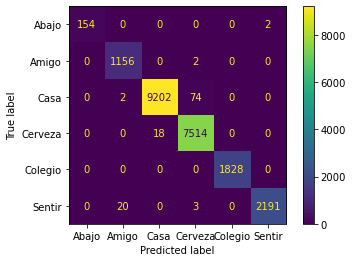

In [22]:
clf = SVC(random_state=0)
clf.fit(X_train, y_train)
SVC(random_state=0)
plot_confusion_matrix(clf, X_test, y_test)  


In [16]:
fit_models['sv'].predict(X_test)

array(['Amigo', 'Cerveza', 'Cerveza', ..., 'Casa', 'Cerveza', 'Cerveza'],
      dtype=object)

In [17]:
y_test

3907       Amigo
54958    Cerveza
58196    Cerveza
25407       Casa
12882       Casa
          ...   
59625    Cerveza
1363       Amigo
16032       Casa
48967    Cerveza
51638    Cerveza
Name: Word, Length: 22166, dtype: object

In [21]:
# df.to_csv("data.csv", index = False)

In [17]:
with open('body_language.pkl', 'wb') as f:
    pickle.dump(fit_models['sv'], f)

In [3]:
# Load model
with open('./body_language.pkl', 'rb') as f:
    model = pickle.load(f)

In [4]:
model

Pipeline(steps=[('minmaxscaler', MinMaxScaler()), ('svc', SVC())])

In [6]:
cap = cv2.VideoCapture(0)
# Initialize holistic model
with mp_holistic.Holistic(min_detection_confidence = 0.5, min_tracking_confidence = 0.5) as holistic:
    while cap.isOpened():
        # Read frame
        ret, frame = cap.read()
        if ret == True:
            # Resize frame
            #frame = cv2.resize(frame, (WIDTH, HEIGHT), interpolation = cv2.INTER_AREA)
            # Change color from BGR to RGB
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            frame.flags.writeable = False
            # Detect landmarks
            results = holistic.process(frame)
            
             # Mano izquieda (azul)
            mp_drawing.draw_landmarks(
                frame, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS,
                mp_drawing.DrawingSpec(color=(255, 255, 0), thickness=2, circle_radius=1),
                mp_drawing.DrawingSpec(color=(255, 0, 0), thickness=2))

           # Mano derecha (verde)
            mp_drawing.draw_landmarks(
                frame, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS,
                mp_drawing.DrawingSpec(color=(0, 255, 0), thickness=2, circle_radius=1),
                mp_drawing.DrawingSpec(color=(57, 143, 0), thickness=2))

           # Postura
            mp_drawing.draw_landmarks(
                frame, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS,
                mp_drawing.DrawingSpec(color=(128, 0, 255), thickness=2, circle_radius=1),
                mp_drawing.DrawingSpec(color=(255, 255, 255), thickness=2))
            
            try:
                
                # Add coords to list row
                row = []
                # The name of the word is added to the row list.
                #row.append(word)
                ## Get rhand landmarks
                try:
                    for landmark in results.right_hand_landmarks.landmark:
                        row.append(landmark.x)
                        row.append(landmark.y)
                        row.append(landmark.z)
                except:
                    pass
                ## Get lhand landmarks
                try:
                    for landmark in results.left_hand_landmarks.landmark:
                        row.append(landmark.x)
                        row.append(landmark.y)
                        row.append(landmark.z)
                except:
                    pass
                    
                ## Get pose landmarks
                
                try:
                    count = 0
                    for landmark in results.pose_landmarks.landmark:
                        row.append(landmark.x)
                        row.append(landmark.y)
                        row.append(landmark.z)
                        count += 1
                        if count == 15:
                            break
                except:
                    pass

            except:
                pass
                        
           
            if len(row)==171:
                       
            
                X = pd.DataFrame([row])
            
                body_language_class = model.predict(X)[0]
                #body_language_prob = model.predict_proba(X)[0]
                print(body_language_class)

                #Grab ear coords
            #puntos de referencia desde donde coger las coordenadas para poner el rectangulo del cartelito(aqui las orejas) 
                coords = tuple(np.multiply(
                                np.array(
                                    (results.pose_landmarks.landmark[mp_holistic.PoseLandmark.LEFT_EAR].x, 
                                     results.pose_landmarks.landmark[mp_holistic.PoseLandmark.LEFT_EAR].y))
                            , [640,480]).astype(int))
            #RECTANGULO
                cv2.rectangle(frame, 
                              (coords[0], coords[1]+5), 
                              (coords[0]+len(body_language_class)*20, coords[1]-30), 
                              (245, 117, 16), -1)
            
            #TEXTO DENTRO RECTANGULO
                cv2.putText(frame, body_language_class, coords, 
                            cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
            
            
            
            # Get status box
                cv2.rectangle(frame, (0,0), (250, 60), (245, 117, 16), -1)
            
            # Display Class
                cv2.putText(frame, 'CLASS'
                            , (95,12), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 1, cv2.LINE_AA)
                cv2.putText(frame, body_language_class.split(' ')[0]
                            , (90,40), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
            
#             # Display Probability
#                 cv2.putText(frame, 'PROB'
#                             , (15,12), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 1, cv2.LINE_AA)
#                 cv2.putText(frame, str(round(body_language_prob[np.argmax(body_language_prob)],2))
#                             , (10,40), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
            
   
          
           
            frame = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)
            cv2.imshow("Imagen a detectar", frame)
            if cv2.waitKey(10) & 0xFF == ord('q'):
                    break
        else:
            break
cap.release()
cv2.destroyAllWindows()

Sentir
Sentir
Sentir
Sentir
Cerveza
Cerveza
Casa
Casa
Casa
Casa
Casa
Casa
Casa
Casa
Casa
Casa
Casa
Casa
Casa
Casa
Casa
Casa
Casa
Casa
Casa
Casa
Casa
Casa
Casa
Casa
Casa
Sentir
Sentir
Sentir
Sentir
Sentir
Sentir
Sentir
Sentir
Sentir
Sentir
Sentir
Sentir
Sentir
Sentir
Sentir
Sentir
Sentir
Sentir
Sentir
Sentir
Sentir
Sentir
Sentir
Sentir
Sentir
Cerveza
Cerveza
Cerveza
Cerveza
Cerveza
Cerveza
Cerveza
Cerveza
Cerveza
Cerveza
Cerveza
Cerveza
Cerveza
Cerveza
Cerveza
Cerveza
Cerveza
Cerveza
Cerveza
Cerveza
Cerveza
Cerveza
Sentir
Sentir
Sentir
Sentir
Sentir
Sentir
Sentir
Sentir
Sentir
Sentir
Sentir
Sentir
Sentir
Sentir
Sentir
Sentir
Sentir
Sentir
Sentir
Sentir
Sentir
Sentir
Sentir
Sentir
Cerveza
Cerveza
Amigo
Amigo
Amigo
Amigo
Amigo
Amigo
Amigo
Amigo
